In [1]:
from sklearn import datasets
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
d = datasets.load_digits()
X = d.data
y = d.target
print(X.shape, y.shape)

(1797, 64) (1797,)


1. Создайте DecisionTreeClassifier с настройками по умолчанию и измерьте качество его работы с помощью cross_val_score.

In [3]:
tree = DecisionTreeClassifier()
res = cross_val_score(tree, X, y, cv=10)
print(res.mean())

0.8152234636871508


2. Воспользуйтесь BaggingClassifier из sklearn.ensemble, чтобы обучить бэггинг над DecisionTreeClassifier. Используйте в BaggingClassifier параметры по умолчанию, задав только количество деревьев равным 100.<p>Качество классификации новой модели - ответ в данном задании. Обратите внимание, как соотносится качество работы композиции решающих деревьев с качеством работы одного решающего дерева.

In [4]:
tree = DecisionTreeClassifier()
res = cross_val_score(tree, X, y, cv=10).mean()
print('DecisionTreeClassifier', res)
bagging = BaggingClassifier(n_estimators=100)
res = cross_val_score(bagging, X, y, cv=10).mean()
print('BaggingClassifier', res)

DecisionTreeClassifier 0.8336157666045935
BaggingClassifier 0.9254003724394785


3. Теперь изучите параметры BaggingClassifier и выберите их такими, чтобы каждый базовый алгоритм обучался не на всех d признаках, а на $\sqrt{d}$ случайных признаков.<p>Качество работы получившегося классификатора - ответ в данном задании. Корень из числа признаков - часто используемая эвристика в задачах классификации, в задачах регрессии же часто берут число признаков, деленное на три. Нов общем случае ничто не мешает вам выбирать любое другое число случайных признаков.

In [5]:
tree = DecisionTreeClassifier()
bagging = BaggingClassifier(base_estimator=tree, n_estimators=100, max_features=8)
res = cross_val_score(bagging, X, y, cv=10).mean()
print(res)

0.9198572315332093


4. Наконец, давайте попробуем выбирать случайные признаки не один раз на все дерево, а при построении каждой вершины дерева. Сделать это несложно: нужно убрать выбор случайного подмножества признаков в BaggingClassifier и добавить его в DecisionTreeClassifier. Какой параметр за это отвечает, можно понять из документации sklearn, либо просто попробовать угадать (скорее всего, у вас сразу получится). Попробуйте выбирать опять же $\sqrt{d}$ признаков. Качество полученного классификатора на контрольной выборке и будет ответом в этом пункте.

In [6]:
tree = DecisionTreeClassifier(max_features=8)
bagging = BaggingClassifier(base_estimator=tree, n_estimators=100)
res = cross_val_score(bagging, X, y, cv=10).mean()
print(res)

0.9487988826815641


5. Полученный в пункте 4 классификатор - бэггинг на рандомизированных деревьях (в которых при построении каждой вершины выбирается случайное подмножество признаков и разбиение ищется только по ним). Это в точности соответствует алгоритму Random Forest, поэтому почему бы не сравнить качество работы классификатора с RandomForestClassifier из sklearn.ensemble. Сделайте это, а затем изучите, как качество классификации на данном датасете зависит от количества деревьев, количества признаков, выбираемых при построении каждой вершины дерева, а также ограничений на глубину дерева. Для наглядности лучше построить графики зависимости качества от значений параметров, но для сдачи задания это делать не обязательно.

In [7]:
rfc = RandomForestClassifier(max_features=8, n_estimators=100)
res = cross_val_score(rfc, X, y, cv=10).mean()
print(res)

0.9538081936685288


Анализ зависимости качества классификации от числа деревьев

In [8]:
n_estimators = np.arange(5, 205, 10)
scores = []
for n in n_estimators:
    rfc = RandomForestClassifier(n_estimators=n)
    scores.append(cross_val_score(rfc, X, y, cv=10).mean())

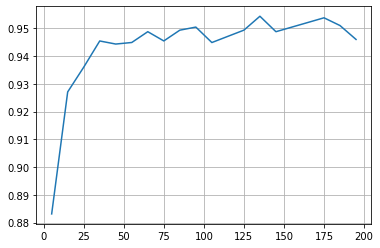

In [9]:
plt.plot(n_estimators, scores)
plt.grid()

Анализ зависимости качества классификации от числа признаков, выбираемых при построении каждой вершины

In [10]:
maxf = [2 ** i for i in range(7)]
scores = []
for m in maxf:
    rfc = RandomForestClassifier(max_features=m)
    scores.append(cross_val_score(rfc, X, y, cv=10).mean())

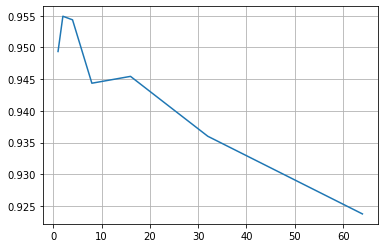

In [11]:
plt.plot(maxf, scores)
plt.grid()
plt.show()

Анализ зависимости качества классификации от ограничений на глубину дерева

In [12]:
depth = np.arange(5, 100, 5)
scores = []
for d in depth:
    rfc = RandomForestClassifier(max_depth=d)
    scores.append(cross_val_score(rfc, X, y, cv=10).mean())

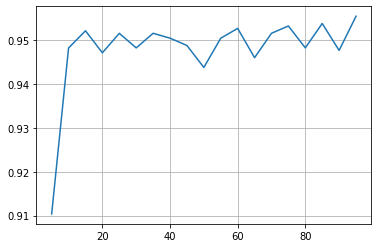

In [13]:
plt.grid()
plt.plot(depth, scores)
plt.show()

Выводы:

При очень маленьком числе деревьев (5, 10, 15), случайный лес работает хуже, чем при большем числе деревьев

С ростом количества деревьев в случайном лесе, в какой-то момент деревьев становится достаточно для высокого качества классификации, а затем качество существенно не меняется.

При большом количестве признаков (для данного датасета - 40, 50) качество классификации становится хуже, чем при малом количестве признаков (5, 10). Это связано с тем, что чем меньше признаков выбирается в каждом узле, тем более различными получаются деревья (ведь деревья сильно неустойчивы к изменениям в обучающей выборке), и тем лучше работает их композиция.

При небольшой максимальной глубине деревьев (5-6) качество работы случайного леса заметно хуже, чем без ограничений, т.к. деревья получаются недообученными. С ростом глубины качество сначала улучшается, а затем не меняется существенно, т.к. из-за усреднения прогнозов и различий деревьев их переобученность в бэггинге не сказывается на итоговом качестве (все деревья преобучены по-разному, и при усреднении они компенсируют переобученность друг друга).